## The Notebook for 2-photo dissociation Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from processing import ProcessData
from constants import ApproachEnum, MeasureEnum, lifetime_outfile, confidence, plot_params, succ_rate_outfile, outplotdir
from pathlib import Path
from scipy.constants import h, c
%matplotlib inline

### Process dissociation data

In [2]:
task = 'run_7'
process = ProcessData(task, copy_files=False, do_2photon=True, process_y_line_sum=False)

In [3]:
process.run(do_int=True, do_liv=True, plot=True, save_plot=True)

In [4]:
df = pd.read_csv(lifetime_outfile(task, MeasureEnum.live, ApproachEnum.bayesian), sep="    ", engine="python")
df

,wl(nm),mean_lt(s),mle_lt(s),CI_low[lt],CI_high[lt],int(W/m2),int_er,label,file
0,530,1566.707626,1092.9,875.7,2330.1,1.452523e+06,273665.236239,530 p12000 1 230803,2023_08_10_10h_28m_50s_dissociation_measurement
1,500,90.565789,81.9,70.2,110.4,1.246128e+06,210383.194687,500 p12000 1 230803,2023_08_11_10h_41m_37s_dissociation_measurement
2,510,66.834286,60.9,52.5,80.7,1.439178e+06,264887.444439,510 p12000 1 230814,2023_08_14_11h_36m_53s_dissociation_measurement
3,520,127.991875,113.7,96.9,158.4,1.307099e+06,227479.158171,520 p12000 1 230816,2023_08_16_10h_59m_25s_dissociation_measurement
4,525,172.153333,151.8,129.3,214.2,1.374755e+06,247159.850180,525 p12000 1 230818,2023_08_18_11h_15m_57s_dissociation_measurement
5,535,592.632467,424.5,354.9,818.1,1.376111e+06,246833.928335,535 p12000 1 230821,2023_08_21_12h_09m_33s_dissociation_measurement
6,540,1114.579439,676.5,572.4,1705.8,1.330288e+06,241156.317639,540 p12000 1 230822,2023_08_22_00h_00m_00s_dissociation_measurement


### Pulse duration data

In [5]:
t_pulse_dict = {500: 96.79670638861498,
 510: 91.19347614946551,
 525: 117.99118518659529,
 535: 121.3027133559515,
 540: 140.64072556497126,
 520: 97.4451907352194,
 530: 140.0376446032355}
t_pulse = np.array([t_pulse_dict[wl] for wl in df["wl(nm)"].values])
t_pulse

array([140.0376446 ,  96.79670639,  91.19347615,  97.44519074,
       117.99118519, 121.30271336, 140.64072556])

### Monte Carlo uncertainty calculation

In [6]:
def samples_file_intensity(measurement):
    return Path().cwd().joinpath(f'samples/samples_intensity/{measurement}_intensity.npy')
def samples_file_lifetime(measurement, meas_type:MeasureEnum):
    return Path().cwd().joinpath(f'samples/samples_lifetime/{measurement}_lifetime_{meas_type.value}.npy')
def samples_array_intensity():
    samples_list = []
    for measurement in process.data.datainfo_json.keys():
        with open(samples_file_intensity(measurement), 'rb') as f:
            samples = np.load(f)
            samples_list.append(samples)
    return np.array(samples_list).T
def samples_array_lifetime(meas_type:MeasureEnum):
    samples_list = []
    for measurement in process.data.datainfo_json.keys():
        with open(samples_file_lifetime(measurement, meas_type), 'rb') as f:
            samples = np.load(f)
            samples_list.append(samples)
    return np.array(samples_list).T

In [7]:
samples_intensity = samples_array_intensity()
print(np.mean(samples_intensity, axis=0))
samples_lifetime = samples_array_lifetime(MeasureEnum.live)
print(np.mean(samples_lifetime, axis=0))

wavelength = df["wl(nm)"].values
intensity = df["int(W/m2)"].values
lifetime = df["mle_lt(s)"].values
conv = np.sqrt(np.pi/2/np.log(2)) * 20e3 * 1e-15 * 2 * (h * c / 1e-9)**2 / 1e-8 * 1e50
# rep rate: 20kHz ; pulse length in fs
# nm(1e-9), cm^4(1e-8), cross section(1e-50 after multipling photon energy)
cs = conv * t_pulse / lifetime / intensity / intensity / wavelength / wavelength
d_cs = []
for i, w in enumerate(wavelength):
    _samples = (conv * t_pulse[i] / samples_lifetime.T[i] / samples_intensity.T[i] / samples_intensity.T[i] / w / w)
    d_cs.append([
        cs[i] - np.percentile(_samples, (1-confidence)/2*100),
        np.percentile(_samples, (1+confidence)/2*100) - cs[i]
    ])
d_cs = np.array(d_cs).T

[1452522.96481629 1246128.48332737 1439178.09123483 1307098.74302696
 1374755.37322991 1376110.66491582 1330287.90785381]
[1568.524875   90.46635    66.880089  127.849401  172.2801    593.265786
 1110.811443]


In [8]:
print(cs)
print(d_cs)

[0.00513721 0.07233886 0.06604466 0.04407955 0.03545431 0.01252677
 0.0095725 ]
[[0.00287686 0.02577856 0.0239226  0.01659896 0.0137521  0.00662137
  0.00595096]
 [0.00224895 0.03007952 0.03030396 0.01901874 0.01567622 0.00497026
  0.00333979]]


### Cross section plot

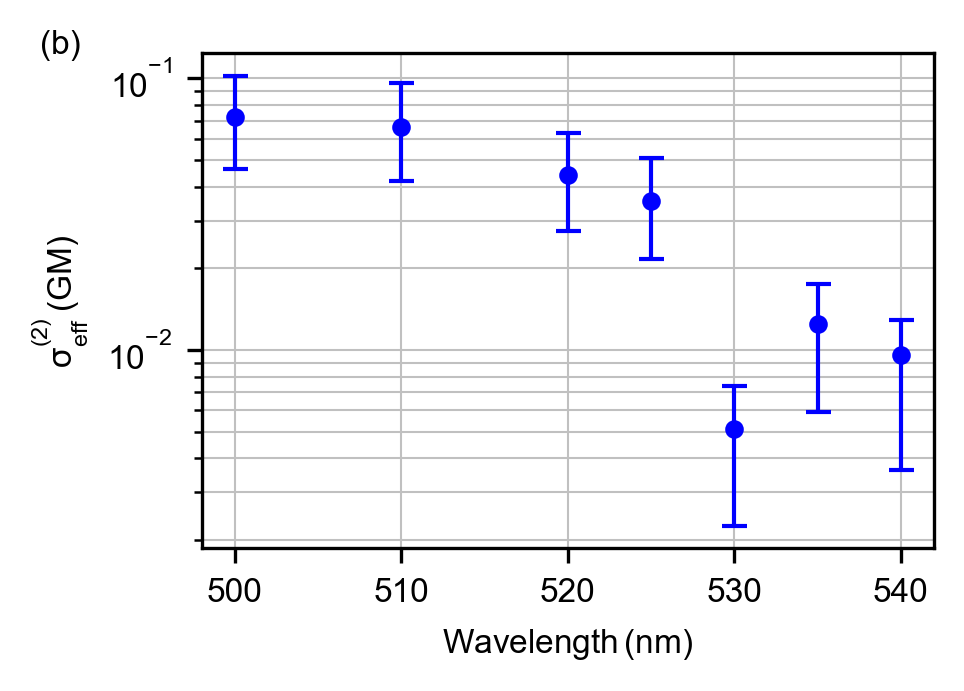

In [9]:
plt.rcParams.update(plot_params)
fig, ax = plt.subplots()
ax.scatter(wavelength, cs, marker="o", c="b", s=12, zorder=10)
ax.errorbar(wavelength, cs, yerr=d_cs, fmt="", ls="none", ecolor="b", elinewidth=1.0, capsize=3.0, capthick=1.0)
ax.set_xlabel(r"$Wavelength \, (nm)$")
ax.set_ylabel(r"$\sigma_{eff}^{(2)} \, (GM)$")
ax.grid(True, which="both")
ax.set_yscale("log")
ax.text(-0.22, 1.0, "(b)", transform=plt.gca().transAxes)
plt.savefig('spectrum_2photon.eps', format='eps', dpi=300)

### Memorylessness verification based on interval data

In [10]:
df1 = pd.read_csv(lifetime_outfile(task, MeasureEnum.intervals, ApproachEnum.bayesian), sep="    ", engine="python")
df1

,wl(nm),mean_lt(s),mle_lt(s),CI_low[lt],CI_high[lt],int(W/m2),int_er,label,file
0,530,1537.487819,1051.2,848.4,2301.9,1.450163e+06,271960.267620,530 p12000 1 230803,2023_08_10_10h_28m_50s_dissociation_measurement
1,500,101.643728,92.4,79.2,123.6,1.245299e+06,208973.562094,500 p12000 1 230803,2023_08_11_10h_41m_37s_dissociation_measurement
2,510,57.374435,52.2,44.7,69.6,1.437625e+06,263091.609615,510 p12000 1 230814,2023_08_14_11h_36m_53s_dissociation_measurement
3,520,121.266237,107.7,91.8,150.0,1.306735e+06,226103.935527,520 p12000 1 230816,2023_08_16_10h_59m_25s_dissociation_measurement
4,525,167.896618,149.1,127.2,207.9,1.376045e+06,248400.858932,525 p12000 1 230818,2023_08_18_11h_15m_57s_dissociation_measurement
5,535,603.927274,432.6,361.8,833.7,1.377683e+06,248557.972569,535 p12000 1 230821,2023_08_21_12h_09m_33s_dissociation_measurement
6,540,1179.802979,732.0,616.8,1799.1,1.329030e+06,239757.779538,540 p12000 1 230822,2023_08_22_00h_00m_00s_dissociation_measurement


In [11]:
df2 = pd.read_csv(succ_rate_outfile(task), sep="    ", engine="python")
df2

,wl(nm),1,5,10,30,60,file
0,530,0.000000,0.000000,0.021739,0.035714,0.038462,2023_08_10_10h_28m_50s_dissociation_measurement
1,500,0.000000,0.058824,0.107143,0.208333,0.545455,2023_08_11_10h_41m_37s_dissociation_measurement
2,510,0.000000,0.000000,0.285714,0.500000,0.666667,2023_08_14_11h_36m_53s_dissociation_measurement
3,520,0.057143,0.057143,0.066667,0.210526,0.400000,2023_08_16_10h_59m_25s_dissociation_measurement
4,525,0.000000,0.040000,0.000000,0.160000,0.413793,2023_08_18_11h_15m_57s_dissociation_measurement
5,535,0.000000,0.000000,0.023810,0.071429,0.148148,2023_08_21_12h_09m_33s_dissociation_measurement
6,540,0.000000,0.000000,0.025000,0.080000,0.038462,2023_08_22_00h_00m_00s_dissociation_measurement


Plotting for 530 nm


<Figure size 990x660 with 0 Axes>

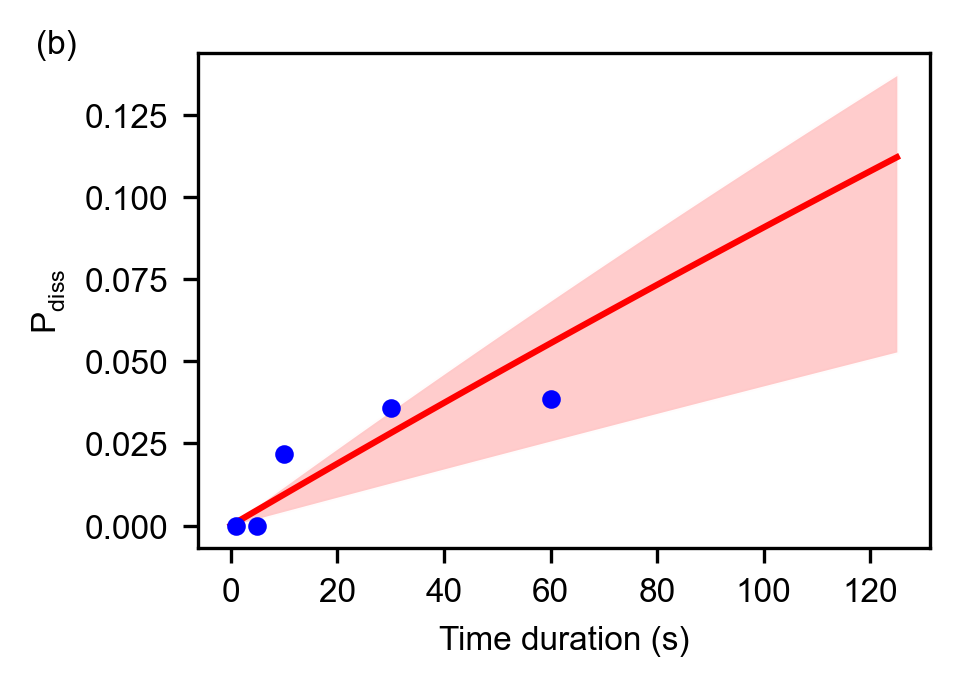

Plotting for 500 nm


<Figure size 990x660 with 0 Axes>

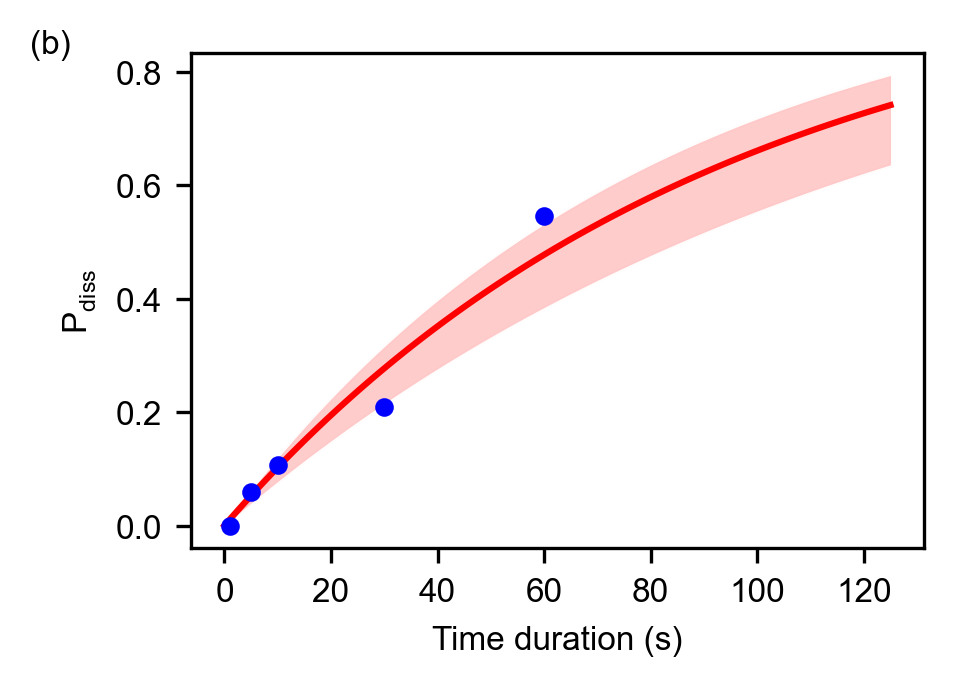

Plotting for 510 nm


<Figure size 990x660 with 0 Axes>

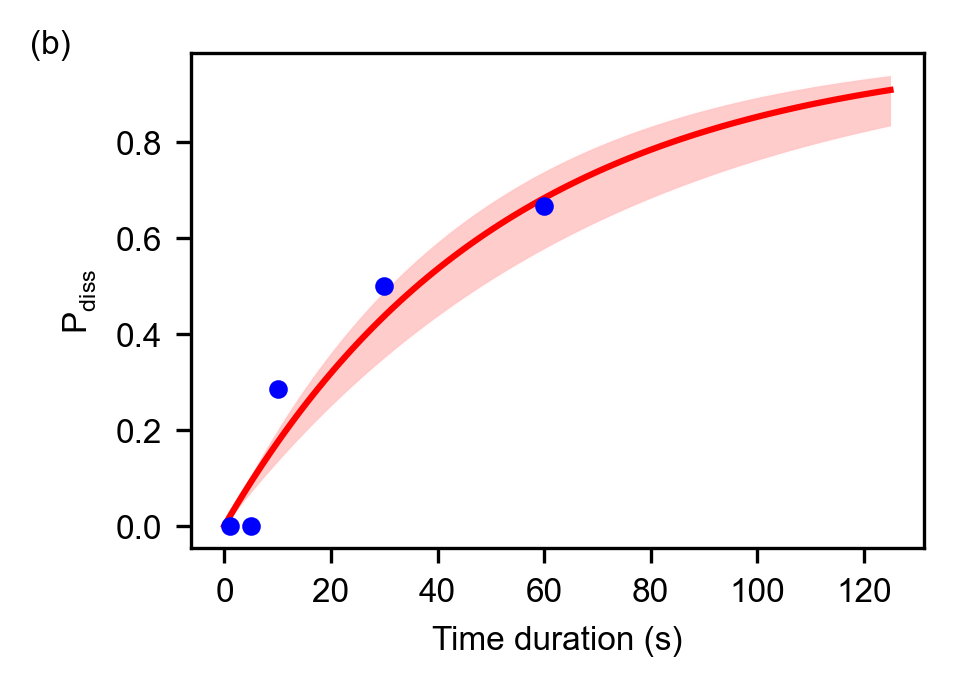

Plotting for 520 nm


<Figure size 990x660 with 0 Axes>

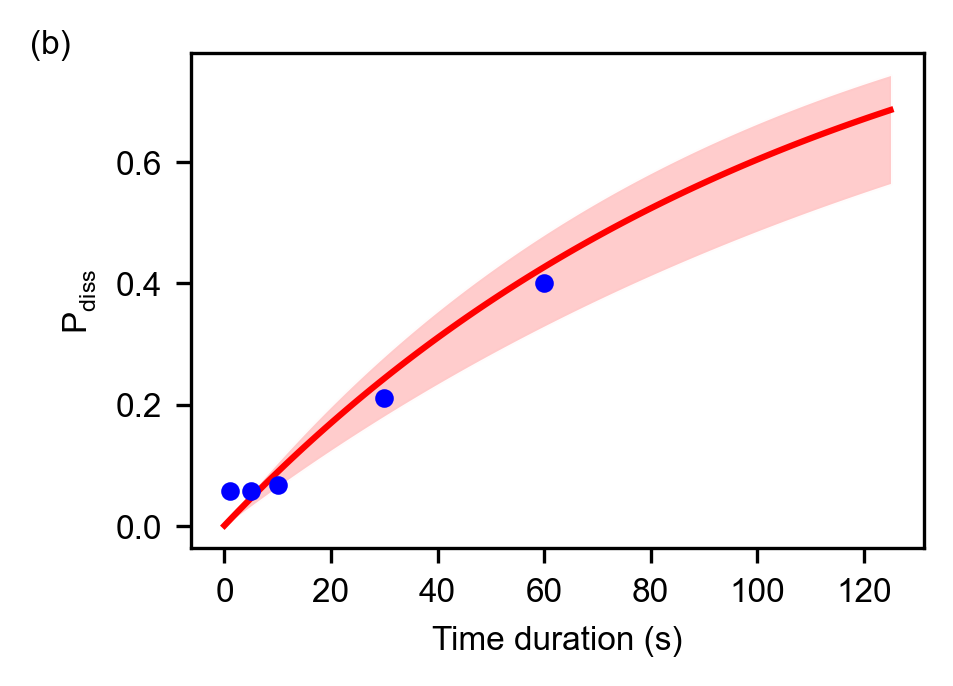

Plotting for 525 nm


<Figure size 990x660 with 0 Axes>

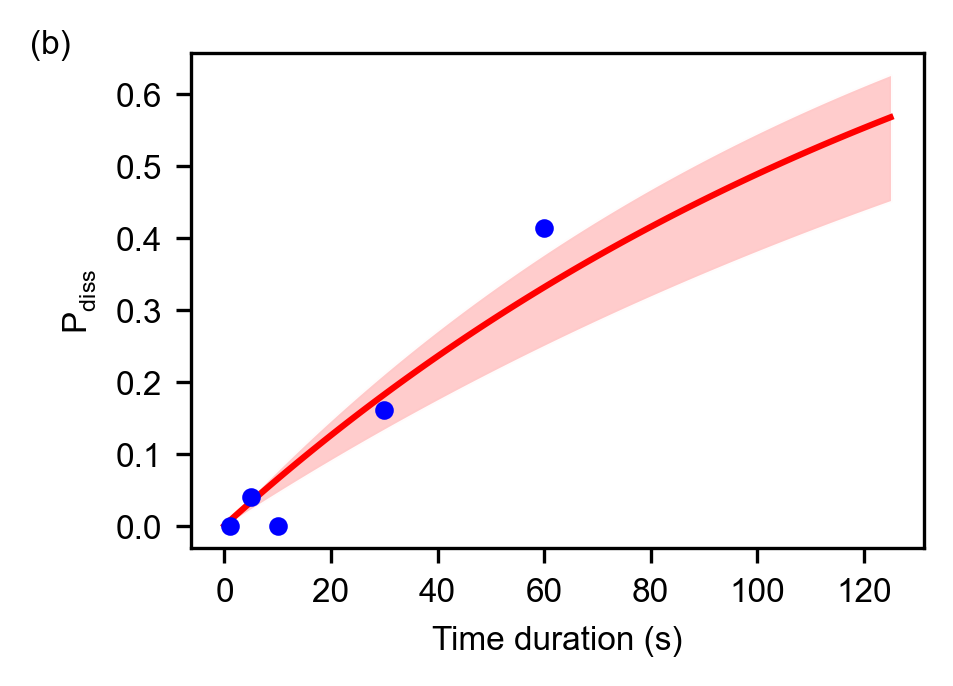

Plotting for 535 nm


<Figure size 990x660 with 0 Axes>

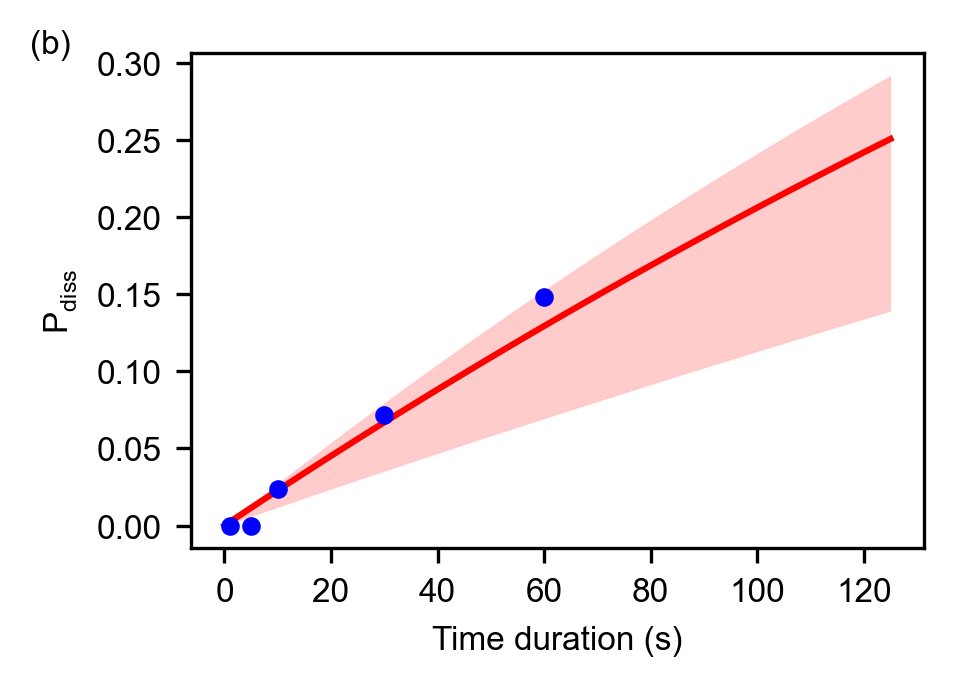

Plotting for 540 nm


<Figure size 990x660 with 0 Axes>

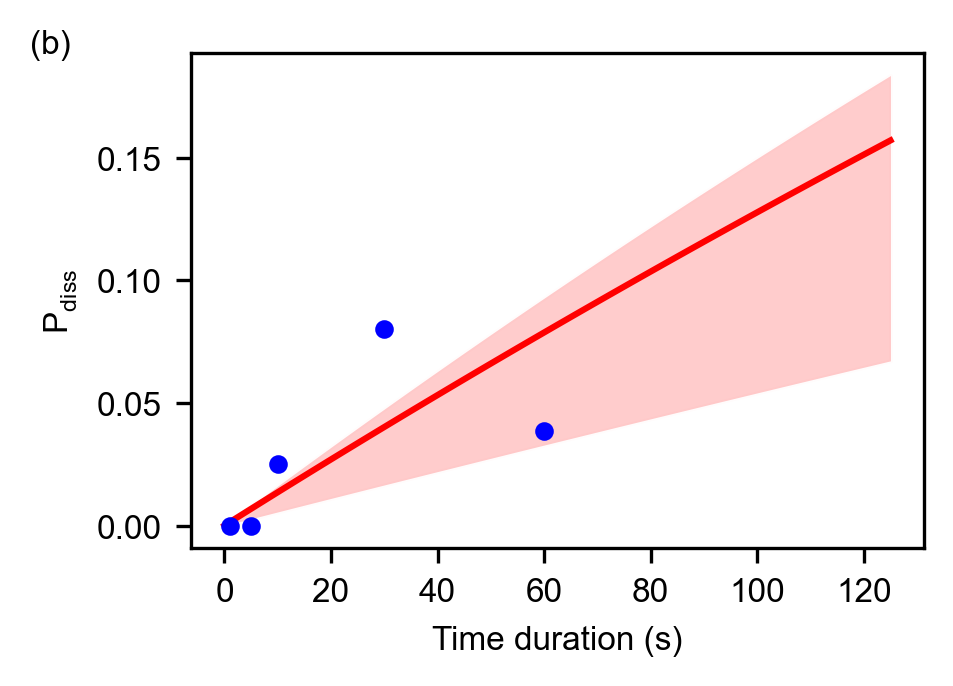

In [12]:
wavelength = df1["wl(nm)"].values
intensity = df1["int(W/m2)"].values
lifetime = df1["mle_lt(s)"].values
lt_high = df1["CI_high[lt]"].values
lt_low = df1["CI_low[lt]"].values
intervals = [1, 5, 10, 30, 60]
x = np.linspace(0, 125, 100)
plt.rcParams.update(plot_params)
for i in range(len(wavelength)):
    plt.clf()
    fig, ax = plt.subplots()
    succ_rates = [df2[str(intv)][i] for intv in intervals]
    ax.scatter(intervals, succ_rates, marker="o", c="b", s=12, zorder=10)
    y = 1 - np.exp(-x/lifetime[i])
    y_low = 1 - np.exp(-x/lt_high[i])
    y_high = 1 - np.exp(-x/lt_low[i])
    ax.plot(x, y, '-', c='r')
    ax.fill_between(x, y_low, y_high, facecolor=(1,0,0,.2), edgecolor=(1,0,0,.01))
    ax.set_xlabel(r"Time duration (s)")
    ax.set_ylabel(r"$P_{diss}$")
    # ax.set_title(f"Dissociation probability at {wavelength[i]} nm")
    ax.text(-0.22, 1.0, "(b)", transform=plt.gca().transAxes)
    ax.set_rasterized(True)
    plt.savefig(outplotdir(task).joinpath(f'dissociation_probability_vs_time_duration_{wavelength[i]}_nm.pdf'), format='pdf', dpi=300)
    print(f"Plotting for {wavelength[i]} nm")
    plt.show()

### Compare between real-time and interval based spectra

In [13]:
samples_intensity = samples_array_intensity() 
print(np.mean(samples_intensity, axis=0))
samples_lifetime_int = samples_array_lifetime(MeasureEnum.intervals)
print(np.mean(samples_lifetime_int, axis=0))

wavelength = df1["wl(nm)"].values
intensity = df1["int(W/m2)"].values
lifetime = df1["mle_lt(s)"].values
conv = np.sqrt(np.pi/2/np.log(2)) * 20e3 * 1e-15 * 2 * (h * c / 1e-9)**2 / 1e-8 * 1e50
# rep rate: 20kHz ; pulse length in fs
# nm(1e-9), cm^4(1e-8), cross section(1e-50 after multipling photon energy)
cs_int = conv * t_pulse / lifetime / intensity / intensity / wavelength / wavelength
d_cs_int = []
for i, w in enumerate(wavelength):
    _samples = (conv * t_pulse[i] / samples_lifetime_int.T[i] / samples_intensity.T[i] / samples_intensity.T[i] / w / w)
    d_cs_int.append([
        cs_int[i] - np.percentile(_samples, (1-confidence)/2*100),
        np.percentile(_samples, (1+confidence)/2*100) - cs_int[i]
    ])
d_cs_int = np.array(d_cs_int).T

[1452522.96481629 1246128.48332737 1439178.09123483 1307098.74302696
 1374755.37322991 1376110.66491582 1330287.90785381]
[1534.832841  101.689281   57.399114  121.367349  167.76327   604.408374
 1178.665527]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


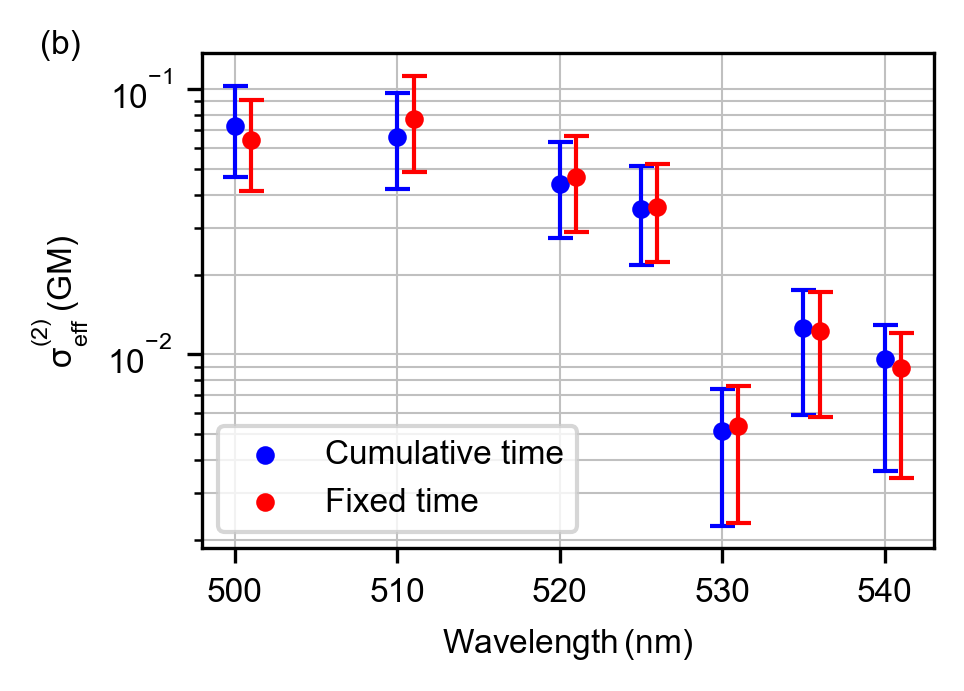

In [17]:
plt.rcParams.update(plot_params)
fig, ax = plt.subplots()
ax.scatter(wavelength, cs, marker="o", c="b", s=12, zorder=10, label="Cumulative time")
ax.errorbar(wavelength, cs, yerr=d_cs, fmt="", ls="none", ecolor="b", elinewidth=1.0, capsize=3.0, capthick=1.0)
ax.scatter(wavelength+1, cs_int, marker="o", c="r", s=12, zorder=20, label="Fixed time")
ax.errorbar(wavelength+1, cs_int, yerr=d_cs_int, fmt="", ls="none", ecolor="r", elinewidth=1.0, capsize=3.0, capthick=1.0, zorder=20)
ax.set_xlabel(r"$Wavelength \, (nm)$")
ax.set_ylabel(r"$\sigma_{eff}^{(2)} \, (GM)$")
ax.grid(True, which="both")
ax.set_yscale("log")
ax.legend()
ax.text(-0.22, 1.0, "(b)", transform=plt.gca().transAxes)
plt.savefig('spectrum_2photon_compare.eps', format='eps', dpi=300)